In [ ]:
import pickle
import os
from tools import *
from candidate import Candidate
from numpy import *
from matplotlib import pyplot as plt
import pandas as pd
from deap import *
from deap.tools.emo import sortNondominated
from qiskit import *
from qiskit.quantum_info import state_fidelity
#from main import LRSP_circs

fitnessWeights = (-1.0, -0.5)
creator.create("FitnessMin", base.Fitness, weights=fitnessWeights)
creator.create("Individual", Candidate, fitness=creator.FitnessMin)

def load_files_by_name(basedir):
    loaded = {}
    for name in  next(os.walk(basedir))[2]:
        with open(os.path.join(basedir, name), 'rb') as file:
            loaded[name] = pickle.load(file)
    return loaded
basedir = 'states/5_qubits'
states = load_files_by_name(basedir)

In [ ]:
states_with_pop = {}
for name, state in states.items():
    try:
        with open(f'performance_data/5QB/400POP/500-30000GEN-{name}.pop', 'rb') as f:
            states_with_pop[name] = {'state': state, 'pop': pickle.load(f)}
    except:
        pass


In [ ]:
'''print(1-pop[19].fitness.values[0])
qc = pop[19].toQiskitCircuit()
display(qc.draw(output='mpl'))



fit = 1-pop[1].fitness.values[0]

# backend = AerSimulator(method='statevector')
backend = Aer.get_backend('statevector_simulator')
result_state1 = backend.run(qc).result().get_statevector()
print(state_fidelity(state_vector, result_state1))'''

In [ ]:
from threading import Thread

def run_init_lrsp_circs(data):
    for name, state in data:
        circs = LRSP_circs(state, initialize_toolbox(state))
        ranks = sortNondominated(circs, len(circs), first_front_only=True)
        front = ranks[0]
        # states_with_pop['lrsp_front'] = front
        f = open('5QB-LRSP-fronts/'+name, 'wb')
        pickle.dump(front, f)
        f.close()
        print(f'finished {name}')

def multithread_chunks(data, chunks, run):
    treds = []
    for i in range(chunks):
        chunk = list(data)[i::chunks]
        print(len(chunk))
        t = Thread(target=run, args=[chunk])
        t.start()
        treds.append(t)

    for t in treds:
        t.join()

In [ ]:
def uniqBy(l, f):
    uniq_so_far = []
    uniq_so_far_mapped = []
    for c in l:
        d = f(c)
        if not d in uniq_so_far_mapped:
            uniq_so_far_mapped.append(d)
            uniq_so_far.append(c)
    return uniq_so_far

lrsp_circs = load_files_by_name('5QB-LRSP-fronts')

lrsp_circs_uniq = {name: uniqBy(circs, lambda c: c.circuit) for name, circs in lrsp_circs.items()}



In [ ]:
from qiskit.providers.aer import QasmSimulator

backend = AerSimulator(method='density_matrix', noise_model=noise_model)
backend = Aer.get_backend('qasm_simulator')
backend = QasmSimulator(method='density_matrix',noise_model=noise_model)

def totalCNOTs(circ):
    cnots = 0
    for gate in circ:
        if (gate[1]==CNOT): cnots+=1
    return cnots

assert states.keys() == lrsp_circs_uniq.keys()


def noisy_simulation_density_matrix(circ):
    circ.save_density_matrix(label='density_matrix')
    #result = backend.run(circ).result()
    result = execute(circ, backend,
                    coupling_map=connectivity,
                    noise_model=noise_model).result()
    return result.data()['density_matrix']

def run_ga_nondominated_noisy_fids(data):
    for name, obj in data:
        data = []
        state = obj['state']
        pop = sortNondominated(obj['pop'], len(obj['pop']), first_front_only=True)[0]
        pop = uniqBy(pop, lambda c: c.circuit)
        for ind in pop:
            ind_data = {'noisy_fids': []}
            permutation = ind.getPermutationMatrix()
            permutation = np.linalg.inv(permutation)
            cnots = totalCNOTs(ind.circuit)
            for _ in range(100): # find the best circuit from noisy results
                circ = ind.toQiskitCircuit()
                circ.measure_all()
                circ = transpile(circ,fake_machine,optimization_level=0)
                permutation2 = getPermutation(circ)
                perm_circ = Permutation(5, permutation2) # Creating a circuit for qubit mapping
                perm_unitary = Operator(perm_circ) # Matrix for the previous circuit
                density_matrix_noisy = noisy_simulation_density_matrix(circ)
                fid = state_fidelity(perm_unitary @ permutation @ state._data, density_matrix_noisy)
                ind_data['noisy_fids'].append(fid)
            ind_data['cnots'] = cnots
            data.append(ind_data)
            print(f'finished an individual')
            
        f = open('5QB-GA-nondominated-noisy-fids/'+name, 'wb')
        #pickle.dump(data, f)
        f.close()
        print(f'finished {name}')  


# multithread_chunks(states_with_pop.items(), 4, run_ga_nondominated_noisy_fids)
run_ga_nondominated_noisy_fids(states_with_pop.items())

In [60]:
import re
os.path.exists('5QB-GA-nondominated-noisy-fids/')
dirname, index = re.match('^(5QB[A-Za-z\-]+)_?(\d+?)?$', '5QB-GA-nondominated-noisy-fids_2').groups()
print(f'{dirname}_{int(index or 0) + 1}')

5QB-GA-nondominated-noisy-fids_3


In [ ]:
with open('5QB-GA-nondominated-noisy-fids/'+'5QB_state100', 'rb') as f:
    print(pickle.load(f))


In [20]:
for name, state in states.items():
    circs = lrsp_circs_uniq[name]

    data = []
    for ind in circs:
        ind_data = {'circ': ind, 'noisy_fids': []}
        for _ in range(100): # find the best circuit from noisy results
            permutation = ind.getPermutationMatrix()
            permutation = np.linalg.inv(permutation)
            cnots = totalCNOTs(ind.circuit)
            circ = ind.toQiskitCircuit()
            circ.measure_all()
            circ = transpile(circ,fake_machine,optimization_level=0)
            permutation2 = getPermutation(circ)
            perm_circ = Permutation(5, permutation2) # Creating a circuit for qubit mapping
            perm_unitary = Operator(perm_circ) # Matrix for the previous circuit
            density_matrix_noisy = noisy_simulation_density_matrix(circ)
            fid = state_fidelity(perm_unitary @ permutation @ state._data, density_matrix_noisy)
            ind_data['noisy_fids'].append(fid)
        data.append(ind_data)
    
    #f = open('5QB-LRSP-noisy-fids/'+name, 'wb')
    #pickle.dump(data, f)
    #f.close()
    print(f'finished {name}')


NameError: name 'lrsp_circs_uniq' is not defined

In [9]:
lrsp_noisy_fids = load_files_by_name('5QB-LRSP-noisy-fids')
ga_nondominated_noisy_fids = load_files_by_name('5QB-GA-nondominated-noisy-fids')

In [10]:
import itertools
n = 5
qubits = range(n)

def avg_ent(psi):
    return sum([qi.entropy(qi.partial_trace(psi, [q])) / 5 for q in qubits])

def avg_2qb_ent(psi):
    return sum([qi.entropy(qi.partial_trace(psi, sub)) / 10 for sub in list(itertools.combinations(qubits, 2))])

def first_qubit_entanglement_entropy(psi):
    rho = qi.partial_trace(psi, [4])
    return qi.entropy(rho)

print(list(itertools.combinations(qubits, 2)))


states_with_avg_ent = {}
states_with_avg_2qb_ent = {}
for name, state in states.items():
    states_with_avg_ent[name] = avg_ent(state)
    states_with_avg_2qb_ent[name] = avg_2qb_ent(state)

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


In [11]:
""" 
    This code block plots the maximum fidelities of LRSP and GA with noise for each state individually.
    Variance in the results for a specific individual is due to different permutations that arise from 
    qiskit transpile function; the noise from cnots in different connections varies. Also, transpile 
    might change/add single qubit gates. 
"""

import qiskit.quantum_info as qi

analysis = {}

for name, results in list(ga_nondominated_noisy_fids.items())[0:]:
    df = pd.DataFrame(results)
    df.noisy_fids = df.noisy_fids.apply(max)
    ga_max_fids = df.groupby('cnots').apply(max)

    data_lrsp = []
    for obj in lrsp_noisy_fids[name]:
        # ent = first_qubit_entanglement_entropy(states[name])
        data_lrsp.append({'cnots': totalCNOTs(obj['circ'].circuit), 'noisy_fids': obj['noisy_fids']})

    df = pd.DataFrame(data_lrsp)
    df.noisy_fids = df.noisy_fids.apply(max)
    lrsp_max_fids = df.groupby('cnots').apply(max)

    analysis[name] = {'ga_max_fids': ga_max_fids, 'lrsp_max_fids': lrsp_max_fids}

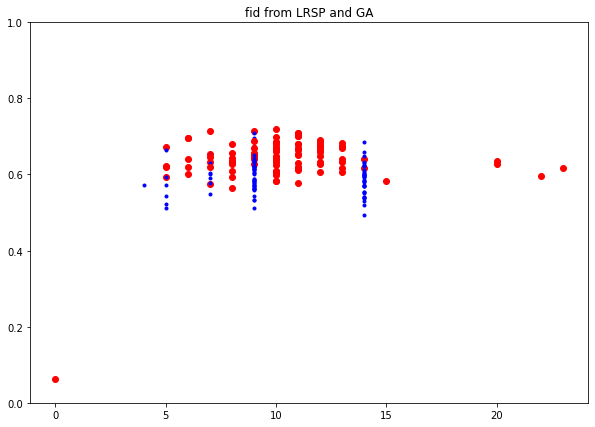

---5QB_state41


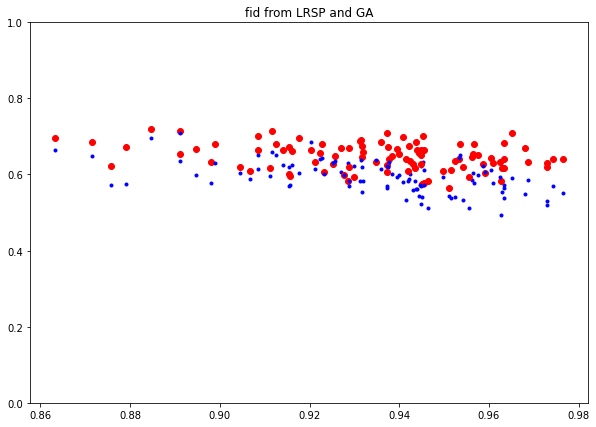

---5QB_state41


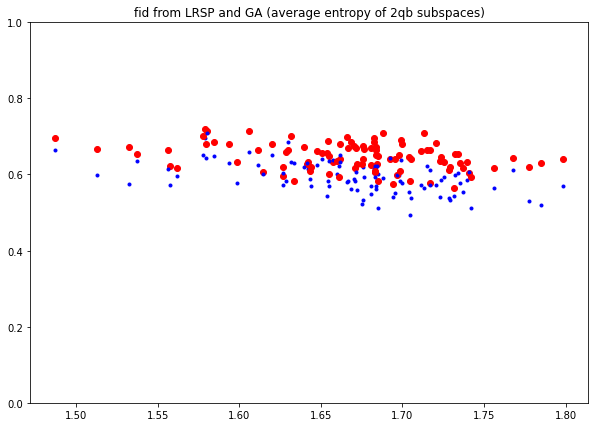

---5QB_state41


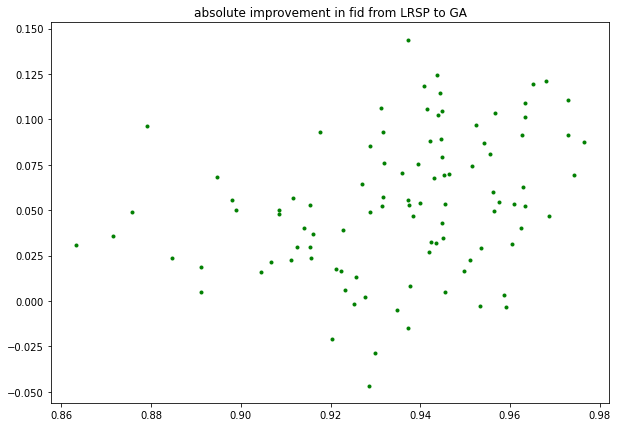

In [19]:
plt.figure(figsize=(10,7))
#plt.ylim(0,1.0)
plt.title('fid from LRSP and GA')

for name, avg_ent in states_with_avg_ent.items():
    data = analysis[name]
    ga_max_fids = data['ga_max_fids']
    lrsp_max_fids = data['lrsp_max_fids']

    ga_best_cnot = ga_max_fids.cnots[ga_max_fids.noisy_fids.eq(ga_max_fids.noisy_fids.max())].max()
    lrsp_best_cnot = lrsp_max_fids.cnots[lrsp_max_fids.noisy_fids.eq(lrsp_max_fids.noisy_fids.max())].max()
    plt.scatter(x=ga_best_cnot, y=ga_max_fids.noisy_fids.max(), color='red')
    plt.scatter(x=lrsp_best_cnot, y=lrsp_max_fids.noisy_fids.max(), color='blue', marker='.')
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(10,7))
plt.title('fid from LRSP and GA')
for name, avg_ent in states_with_avg_ent.items():
    data = analysis[name]
    ga_max_fids = data['ga_max_fids']
    lrsp_max_fids = data['lrsp_max_fids']
    if (name=='5QB_state41'):
        print('---'+name)
        continue
    plt.scatter(x=avg_ent, y=ga_max_fids.noisy_fids.max(), color='red')
    plt.scatter(x=avg_ent, y=lrsp_max_fids.noisy_fids.max(), color='blue', marker='.')
plt.ylim(0,1)
plt.show()


plt.figure(figsize=(10,7))
plt.title('fid from LRSP and GA (average entropy of 2qb subspaces)')
for name, avg_2qb_ent in states_with_avg_2qb_ent.items():
    data = analysis[name]
    ga_max_fids = data['ga_max_fids']
    lrsp_max_fids = data['lrsp_max_fids']
    if (name=='5QB_state41'):
        print('---'+name)
        continue

    plt.scatter(x=avg_2qb_ent, y=ga_max_fids.noisy_fids.max(), color='red')
    plt.scatter(x=avg_2qb_ent, y=lrsp_max_fids.noisy_fids.max(), color='blue', marker='.')
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(10,7))
plt.title('absolute improvement in fid from LRSP to GA')
for name, avg_ent in states_with_avg_ent.items():
    data = analysis[name]
    ga_max_fids = data['ga_max_fids']
    lrsp_max_fids = data['lrsp_max_fids']
    if (name=='5QB_state41'):
        print('---'+name)
        continue

    plt.scatter(x=avg_ent, y=data['ga_max_fids'].noisy_fids.max() - data['lrsp_max_fids'].noisy_fids.max(), color='green', marker='.')


In [ ]:

plt.scatter(*zip(*data))
plt.ylim(0,1)
plt.show()